# 8. 인공지능으로 세상에 없던 새로운 패션 만들기 [프로젝트]

GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

우선 주요 라이브러리 버전을 확인하고 진행합시다.


In [298]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)
print(imageio.__version__)

tensorflow 2.13.0
2.31.3


## STEP 1. 작업환경 구성하기

다음과 같이 작업환경을 구성합시다.

In [299]:
#  mkdir -p aiffel/dcgan_newimage/cifar10/generated_samples
#  mkdir -p aiffel/dcgan_newimage/cifar10/training_checkpoints
#  mkdir -p aiffel/dcgan_newimage/cifar10/training_history

## STEP 2. 데이터셋 구성하기

CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

In [300]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()
print(train_x.shape)
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

(50000, 32, 32, 3)
max pixel: 255
min pixel: 0


각 픽셀은 0~255 사이의 정숫값을 가지며, 총 60,000개의 컬러이미지 데이터가 있습니다. 이 중 50,000개는 학습용으로, 10,000개는 테스트용으로 사용하도록 하겠습니다.

In [301]:
# 정규화
train_x = (train_x / 255.0) * 2 - 1
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


첫번째 데이터를 꺼내어 시각화

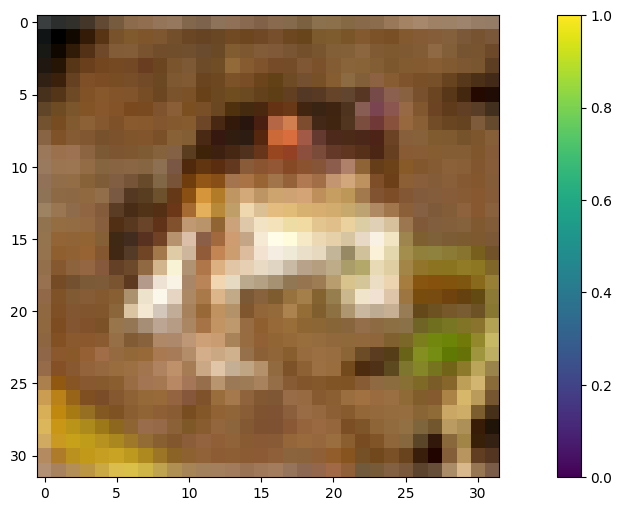

In [302]:
plt.imshow((train_x[0] + 1) / 2.0)
plt.colorbar()
plt.show()

10개의 데이터를 꺼내어 시각화

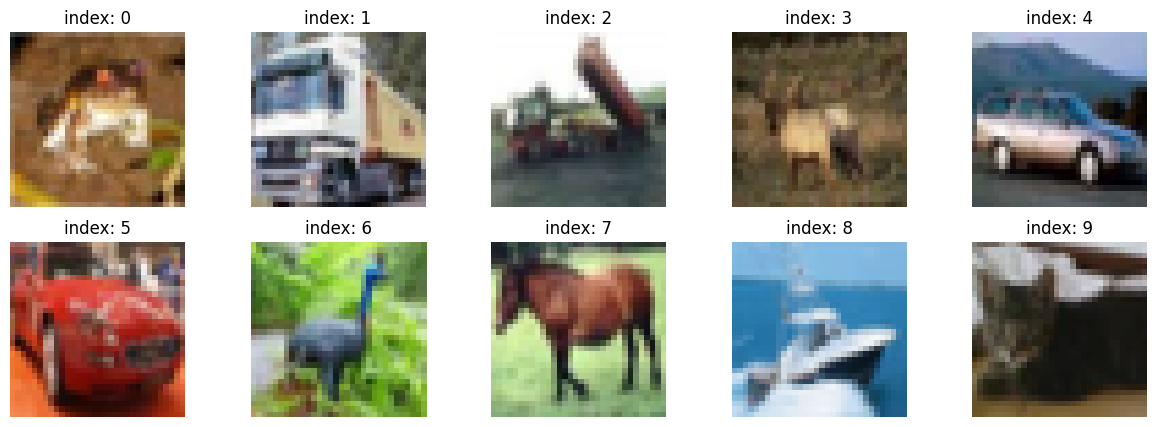

In [303]:
# 10개 데이터 확인
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i] + 1) / 2.0)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.


In [304]:
# 전체 데이터를 섞어서 다시 로드
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [305]:
# 미니배치 학습을 위한 데이터셋 구성
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있습니다. 위 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

## STEP 3. 생성자 모델 구현하기

(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

세 번의 Conv2DTranspose 층을 이용해 (8, 8, 256) → (16, 16, 64) → (32, 32, 3) 순으로 이미지를 키워나갑니다. 여기서 최종 사이즈인 (32, 32,3)은 우리가 준비했던 데이터셋과 형상이 동일합니다.

In [306]:
# GAN generator model 함수
def make_generator_model():

	# Start
	model = tf.keras.Sequential()

	# First: Dense layer
	# units은 7x7x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
	model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Second: Reshape layer
	model.add(layers.Reshape((8, 8, 256)))
	assert model.output_shape == (None, 8, 8, 256) # 주목: 배치사이즈로 None이 주어집니다.
	# Third: Conv2DTranspose layer
	# 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
	model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
	assert model.output_shape == (None, 8, 8, 128)
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Fourth: Conv2DTranspose layer
	# 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
	model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
	assert model.output_shape == (None, 16, 16, 64)
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Fifth: Conv2DTranspose layer
	model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
	assert model.output_shape == (None, 32, 32, 3)
	return model

In [307]:
generator = make_generator_model()

generator.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16384)             1638400   
                                                                 
 batch_normalization_24 (Ba  (None, 16384)             65536     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_8 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_30 (Conv2  (None, 8, 8, 128)         819200    
 DTranspose)                                                     
                                                                 
 batch_normalization_25 (Ba  (None, 8, 8, 128)       

텐서플로우 2.0 이후 버전에서는 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성됩니다 (내부적으로는 생성자의 call 함수가 호출됩니다).

단, 지금은 학습하는 중이 아니니 training=False를 설정해 주어야 합니다! Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 training=False을 주어야 올바른 결과를 얻을 수 있습니다.

In [308]:
noise = tf.random.normal([1,100]) # (1, 100) 형태의 랜덤 노이즈 생성

In [309]:
generated_images = generator(noise, training=False)

[1, 32, 32, 3] 사이즈 이미지 생성 확인 1개의 32,32,3 사이즈 이미지가 생성

이미지 시각화를 통해 생성자가 만든 가짜 이미지를 확인해 봅시다.

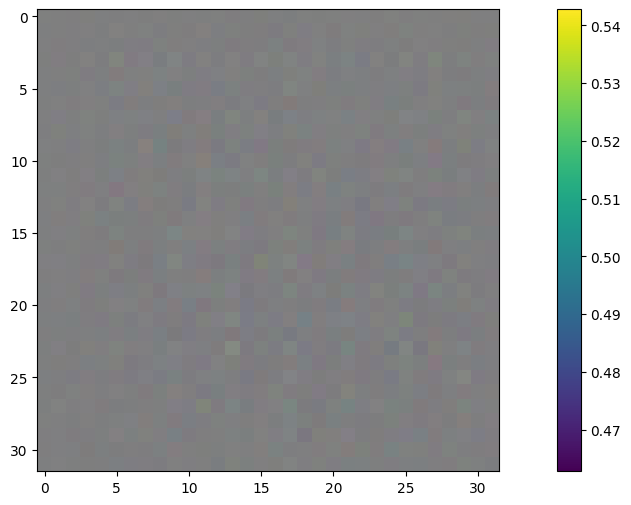

In [310]:
# generated_image 출력
plt.imshow((generated_image[0] + 1) / 2.0)
plt.colorbar()
plt.show()

모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지가 생성

## STEP 4. 판별자 모델 구현하기

(32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [311]:
# GAN discriminator model 함수
def make_discriminator_model():

	# Start
	model = tf.keras.Sequential()

	# First: Conv2D Layer
	# 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
	model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())
	# Dropout은 0.3을 사용
	model.add(layers.Dropout(0.3))

	# Second: Conv2D Layer
	# 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
	model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())
	# Dropout은 0.3을 사용
	model.add(layers.Dropout(0.3))

	# Third: Flatten Layer
	model.add(layers.Flatten())

	# Fourth: Dense Layer
	# 이미지가 실제인지 (1에 가까운 값) 아니면 가짜인지 (0에 가까운 값)를 판별
	model.add(layers.Dense(1))

	return model

In [312]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_14 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_15 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 flatten_7 (Flatten)         (None, 8192)            

Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다. 첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 줄어들게 됩니다.

마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x128=8192, 즉 (1, 8292) 형상의 벡터로 변환합니다. 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다. 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 됩니다.



아까 생성했던 가짜 이미지를 판별자에 입력시켜서 생성자가 만든 이미지를 판별한 결과값을 확인해 봅시다.

In [313]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00094209]], dtype=float32)>

아무 의미 없는 텐서플로우의 텐서를 생성하였음.

## STEP 5. 손실함수와 최적화 함수 구현하기

생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [314]:
# GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용
# 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

fake_output과 real_output을 각각 1 또는 0에 비교를 해야 하는데, 어떻게 비교할 수 있을까요?

바로 tf.ones_like()와 tf.zeros_like() 함수를 활용하면 됩니다. 이 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용합니다. 어떤 식으로 활용되는지, 한번 실험해 볼까요?

In [315]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [316]:
# cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 되겠죠!

In [317]:
# discriminator_loss 값은 이 둘을 더한 값
# 판별자 손실함수
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss =  cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까요? 그렇지 않습니다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻입니다. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻입니다.

In [318]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,

(1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별

tf.Tensor([False, False, True, True])

(2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환

tf.Tensor([0.0, 0.0, 1.0, 1.0])

(3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산

0.5

최적화 함수를 설정할 차례입니다. 이번에는 Adam 최적화 기법 을 활용해 보겠습니다.
생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점입니다.

In [319]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

샘플은 한 번에 16장을 생성하도록 하겠습니다. 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다. 즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다.

In [320]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 6. 훈련과정 상세 기능 구현하기

1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.


In [321]:
@tf.function
def train_step(images):  #(1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
        generated_images = generator(noise, training=True)  #(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성

        #(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True) 

        #(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  # [[YOUR CODE]]

    #(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  # [[YOUR CODE]]

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.


In [322]:
#한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1) / 2.0)
        plt.axis('off')
   
    plt.savefig('{}/aiffel5_quest/exploration/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.


In [323]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel5_quest/exploration/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [324]:
checkpoint_dir = os.getenv('HOME')+'/aiffel5_quest/exploration/aiffel/dcgan_newimage/cifar10/training_checkpoints'
print(checkpoint_dir)

/home/ralphpark/aiffel5_quest/exploration/aiffel/dcgan_newimage/cifar10/training_checkpoints


In [325]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [326]:
#  학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
# 우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
# 아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

# checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

# latest = tf.train.latest_checkpoint(checkpoint_dir)
# checkpoint.restore(latest)

# generator = checkpoint.generator
# discriminator = checkpoint.discriminator

# # 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
# noise = tf.random.normal([1, 100])
# generated_image = generator(noise, training=False)

# np_generated = generated_image.numpy()
# np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
# np_generated = np_generated.astype(int)
# plt.imshow(np_generated[0])
# plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [327]:
# checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있습니다.

# %%time
# train(train_dataset, EPOCHS, save_every)

## STEP 7. 학습 과정 진행하기

위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.

학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.
(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.

우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

In [328]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)


In [329]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

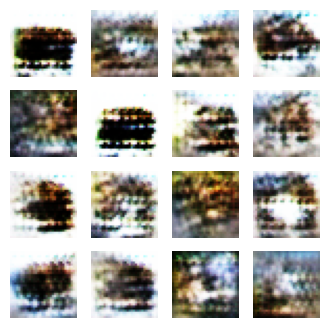

Time for training : 305 sec


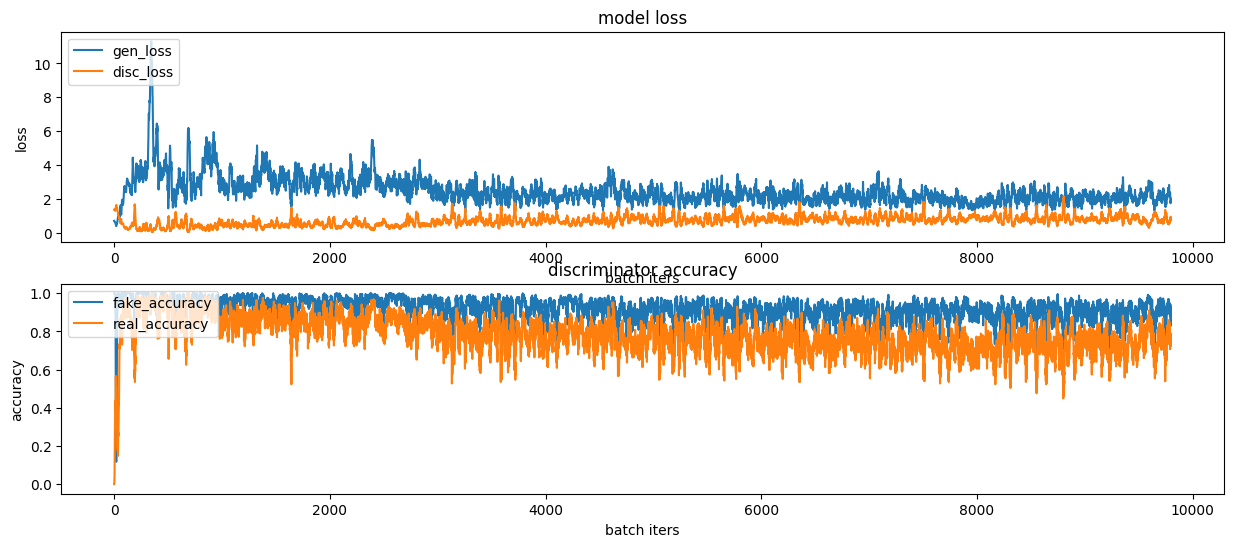

CPU times: user 3min 36s, sys: 1min 18s, total: 4min 55s
Wall time: 5min 6s


In [330]:
%%time
train(train_dataset, EPOCHS, save_every)

In [331]:
anim_file = os.getenv('HOME')+'/aiffel5_quest/exploration/aiffel/dcgan_newimage/cifar10/cifar10.gif'

print(anim_file)

/home/ralphpark/aiffel5_quest/exploration/aiffel/dcgan_newimage/cifar10/cifar10.gif


In [332]:
import os
import imageio
from PIL import Image

# 이미지를 저장할 경로 생성
save_path = os.path.join(os.getenv('HOME'), 'aiffel5_quest', 'exploration', 'aiffel', 'dcgan_newimage', 'cifar10')
os.makedirs(save_path, exist_ok=True)

# 에포크마다 생성된 이미지를 모아서 GIF 파일로 저장
anim_file = os.path.join(save_path, 'cifar10.gif')
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(os.path.join(save_path, 'generated_samples', 'sample*.png'))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        epoch = int(os.path.splitext(os.path.basename(filename))[0].split('_')[2])
        if epoch > last:
            last = epoch
        else:
            continue
        image = Image.open(filename)
        image = image.resize((256, 256))
        writer.append_data(imageio.imread(filename))
    image = Image.open(filename)
    image = image.resize((256, 256))
    writer.append_data(imageio.imread(filename))

print('GIF 파일 저장 완료')

/tmp/ipykernel_14453/406094733.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(filename))
/tmp/ipykernel_14453/406094733.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(filename))


GIF 파일 저장 완료


회고

생성물이 판별가능하지 않은 이미지로 계속 나와서 결론적으로 모델의 개선이 필요하다고 판단하였다.
시간 관계상 많은 부분을 수정하지 못하였지만, 아래와 같은 방법들을 적용하여 모델을 개선할 수 있을 것이라고 생각한다.

1. 모델 아키텍처 개선: 생성자와 판별자의 아키텍처를 조정하여 더 나은 결과물을 생성할 수 있습니다. 레이어 수, 필터 크기, 활성화 함수 등을 조절해 보세요.

2. 학습 파라미터 튜닝: 학습률, 배치 크기 등의 하이퍼파라미터를 조정하여 학습 과정을 개선할 수 있습니다.

3. 더 많은 에폭: 학습을 더 오래 진행하여 모델이 더 많은 데이터를 학습하도록 할 수 있습니다.

4. GAN 변형 사용: DCGAN 이외의 GAN 변형을 사용하여 더 나은 결과를 얻을 수 있습니다. 예를 들어, WGAN, StyleGAN 등을 적용해 보세요.

5. 데이터 증강: CIFAR-10 데이터셋을 더 다양하게 증강하여 모델의 다양한 이미지를 생성할 수 있습니다.

6. 코드 정리: 학습과정을 모니터링하고 결과를 저장하는 코드를 더 효율적으로 관리할 수 있도록 정리하세요.